# Análisis de Consumo Energético y Clustering con Clustering Spectral

## Objetivos del Cuaderno

1. **Generación de Features Agregadas**: Crear nuevas características a partir de los datos originales para representar patrones de consumo de manera más significativa y reducir la dimensionalidad.
2. **Manejo de Valores Faltantes** (KNNImputer o SoftImpute)
3. **Escalado de Características** (`StandardScaler`)
4. **Análisis de Componentes Principales (PCA)**
5. **Selección del Número de Clusters (K)**: Probar diferentes metodos para obtener valores de K y determinar el número óptimo de clusters.
    - **Método del Codo**: Graficar la inercia en función de K y buscar el "codo" en la gráfica.
    - **Silhouette Score**: Calcular el coeficiente de silueta para diferentes valores de K y graficar los resultados.
    - **Davies-Bouldin Index**: Calcular el índice de Davies-Bouldin para diferentes valores de K y graficar los resultados.
    - **K-ISAC-TLP**: Utilizar el método K-ISAC-TLP para determinar el número óptimo de clusters.
        - **ISAC Curves**: Graficar las curvas ISAC para diferentes valores de K y observar la tendencia.
        - **MAE**: Calcular el error absoluto medio (MAE) para diferentes valores de K y graficar los resultados.
        - **Irrelevant clusters**: Identificar y eliminar clusters irrelevantes que no aporten información significativa.
6. **Clustering con Clustering Spectral**: Aplicar el algoritmo de Clustering Spectral para agrupar las viviendas en función de sus patrones de consumo energético.
7. **Validación del Modelo**: Evaluar la calidad de los clusters generados utilizando metedos y visualizaciones adecuadas.
    -  **Visualización de Clusters**: Graficar los clusters generados para observar la distribución de los datos y la separación entre los grupos

## Introducción

El dataset contiene información horaria del consumo energético de aproximadamente 130 viviendas durante un período de dos años. Cada registro incluye:
- **CUPS**: Identificador único de la vivienda.
- **Fecha**: Día específico del registro.
- **Hora**: Hora del día (1 a 24).
- **Consumo_kWh**: Consumo energético en kilovatios-hora.

Dado el volumen de datos, es necesario crear características agregadas que representen patrones de consumo a nivel diario, semanal, mensual, etc., para facilitar el análisis y el clustering.


## Preprocesamiento y Generación de Features

Antes de aplicar el clustering, comenzaremos con:
1. Preprocesamiento y Generación de Features
    - Justificación del Pipeline:
    El preprocesamiento sistemático es crítico porque:
        - **Consistencia**: Las estaciones y tipos de día (laborable/fin de semana) tienen patrones de consumo fundamentalmente distintos.
        - **Robustez**: Las métricas propuestas (percentiles, Lyapunov, FFT) capturan tanto comportamientos típicos como anomalías.
        - **Interpretabilidad**: La separación por contextos naturales (estaciones) facilita la acción sobre resultados.
2. **Creación de Features Agregadas**:
    **Subanálisis (por vivienda):**
    - Primavera
    - Verano
    - Otoño
    - Invierno
    - Análisis general

    **Dentro de cada subanálisis:**
    - Separar en:
    - Días laborables
    - Fines de semana

    **Métricas a calcular para cada parte:**
    | Variable                        | Descripción                                      |
    |---------------------------------|--------------------------------------------------|
    | Media y Desviación Estándar     | Tendencia central y dispersión                  |
    | Asimetría (Skewness)            | Simetría de la distribución                     |
    | Curtosis                        | Picudez/plenitud de la distribución             |
    | Energía (FFT)                   | Potencia acumulada de la señal                  |
    | Frecuencia dominante (FFT)      | Periodicidad más fuerte                         |
    | Mediana y percentiles (25, 75)  | Distribución robusta                            |

3. **Normalización de Datos**: Escalar las características para que todas tengan el mismo rango y no dominen el análisis.

Una vez que los datos estén preprocesados y las nuevas características estén listas, procederemos con la aplicación de K-Means y la evaluación de los resultados.

Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import random
import math
from sklearn.impute import KNNImputer
from fancyimpute import SoftImpute
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, mean_absolute_error, davies_bouldin_score
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../../data/vertical_preprocessed_data_2.csv", sep=";")

Funciones

In [3]:
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    elif mes in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'


def calcular_features(consumos):
    consumos = np.array(consumos)
    if len(consumos) < 2:
        return dict.fromkeys([
            'media', 'std', 'skewness', 'kurtosis',
            'energia_fft', 'frecuencia_dominante',
            'mediana', 'p25', 'p75'
        ], np.nan)

    media = np.mean(consumos)
    std = np.std(consumos)
    skewness = skew(consumos)
    kurt = kurtosis(consumos)

    fft_vals = fft(consumos)
    fft_powers = np.abs(fft_vals)**2
    energia = np.sum(fft_powers) / len(fft_powers)
    frec_dom = np.argmax(fft_powers[1:]) + 1 if len(fft_powers) > 1 else np.nan

    return {
        'media': media,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurt,
        'energia_fft': energia,
        'frecuencia_dominante': frec_dom,
        'mediana': np.median(consumos),
        'p25': np.percentile(consumos, 25),
        'p75': np.percentile(consumos, 75)
    }

In [4]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['hora'].astype(int)
df['dia_semana'] = df['fecha'].dt.dayofweek
df['es_fin_de_semana'] = df['dia_semana'] >= 5
df['mes'] = df['fecha'].dt.month

df['estacion'] = df['mes'].apply(obtener_estacion)

df_grouped = df.groupby(['cups', 'fecha', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# Diccionario donde las claves serán cups y los valores serán diccionarios de features
features_por_cups = {}

# 1. Subanálisis por estación (sin dividir por tipo de día)
for (cups, estacion), grupo in df_grouped.groupby(['cups', 'estacion']):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    prefix = f"{estacion}"

    if cups not in features_por_cups:
        features_por_cups[cups] = {}

    for key, val in feats.items():
        features_por_cups[cups][f"{key}_{prefix}"] = val

# 2. Subanálisis ANUAL completo (sin dividir) - Se mantiene igual
for cups, grupo in df_grouped.groupby('cups'):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    for key, val in feats.items():
        features_por_cups[cups][f"{key}_anual"] = val

df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
df_features_final.reset_index(inplace=True)
df_features_final.rename(columns={'index': 'cups'}, inplace=True)
df_features_final.set_index('cups', inplace=True)

In [5]:
# df['fecha'] = pd.to_datetime(df['fecha'])
# df['hora'] = df['hora'].astype(int)
# df['dia_semana'] = df['fecha'].dt.dayofweek
# df['es_fin_de_semana'] = df['dia_semana'] >= 5
# df['mes'] = df['fecha'].dt.month

# df['estacion'] = df['mes'].apply(obtener_estacion)

# df_grouped = df.groupby(['cups', 'fecha', 'es_fin_de_semana', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# # Diccionario donde las claves serán cups y los valores serán diccionarios de features
# features_por_cups = {}

# # 1. Subanálisis por estación y tipo de día (laboral/finde)
# for (cups, estacion, es_finde), grupo in df_grouped.groupby(['cups', 'estacion', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"{estacion}_{tipo_dia}"
    
#     if cups not in features_por_cups:
#         features_por_cups[cups] = {}
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 2. Subanálisis ANUAL dividido en laboral/finde
# for (cups, es_finde), grupo in df_grouped.groupby(['cups', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"anual_{tipo_dia}"  # Cambiado a "anual_laboral" y "anual_finde"
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 3. Subanálisis ANUAL completo (sin dividir)
# for cups, grupo in df_grouped.groupby('cups'):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_anual"] = val  # Se mantiene igual

# df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
# df_features_final.reset_index(inplace=True)
# df_features_final.rename(columns={'index': 'cups'}, inplace=True)
# df_features_final.set_index('cups', inplace=True)

### Matriz de Correlación

Matriz de Correlación:
                                 media_invierno  std_invierno  \
media_invierno                        1.000000      0.840128   
std_invierno                          0.840128      1.000000   
skewness_invierno                    -0.645887     -0.544706   
kurtosis_invierno                    -0.493550     -0.480077   
energia_fft_invierno                  0.839330      0.874305   
frecuencia_dominante_invierno        -0.104640     -0.068603   
mediana_invierno                      0.866193      0.482343   
p25_invierno                          0.693958      0.280306   
p75_invierno                          0.948512      0.725276   
media_otoño                           0.880786      0.669790   
std_otoño                             0.877199      0.918304   
skewness_otoño                       -0.465249     -0.237981   
kurtosis_otoño                       -0.461140     -0.335243   
energia_fft_otoño                     0.861430      0.830564   
frecuencia_domin

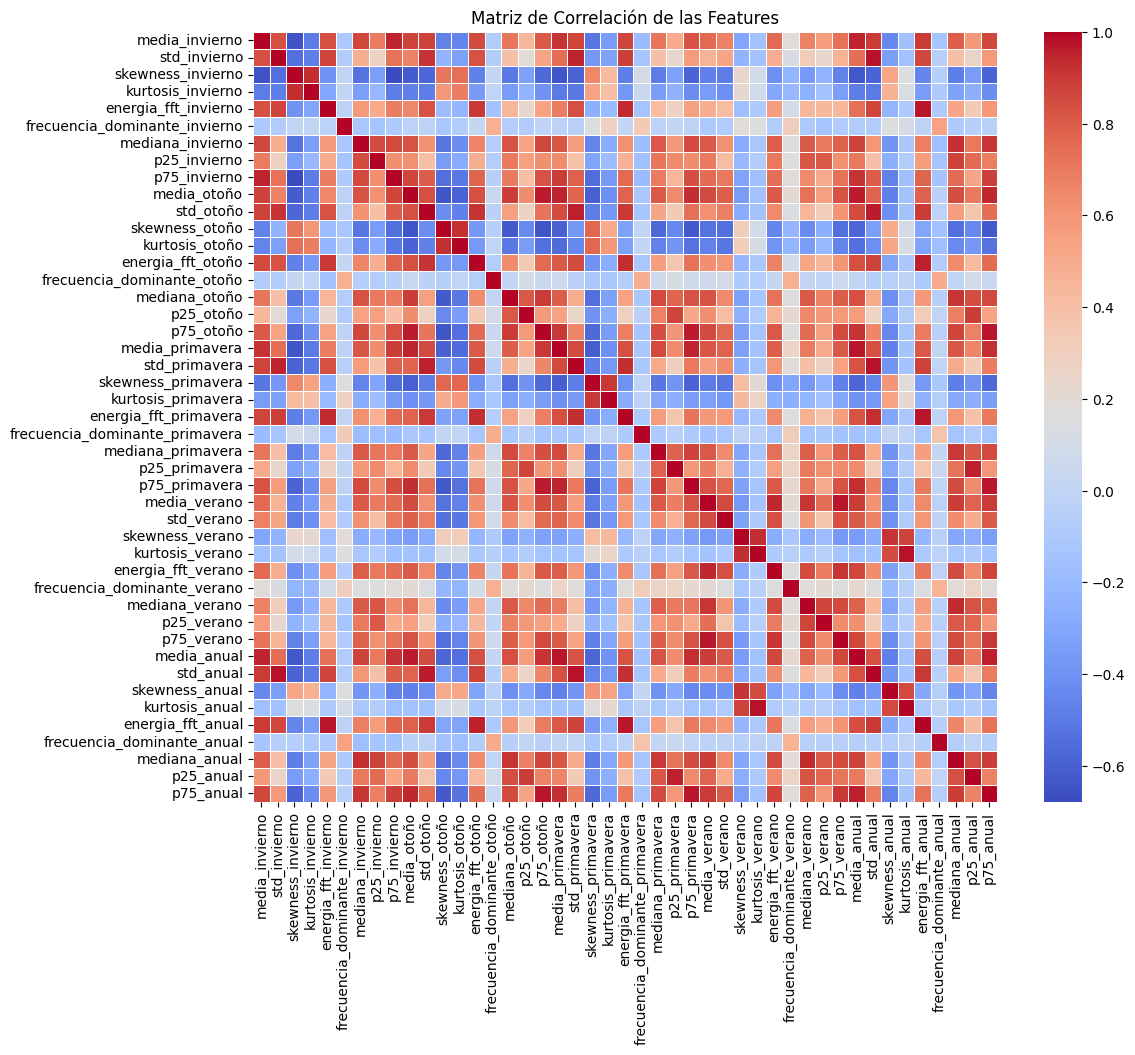


Pares de variables altamente correlacionadas (abs(corr) > 0.8):
 [('std_invierno', 'media_invierno'), ('kurtosis_invierno', 'skewness_invierno'), ('energia_fft_invierno', 'media_invierno'), ('energia_fft_invierno', 'std_invierno'), ('mediana_invierno', 'media_invierno'), ('p25_invierno', 'mediana_invierno'), ('p75_invierno', 'media_invierno'), ('p75_invierno', 'mediana_invierno'), ('media_otoño', 'media_invierno'), ('media_otoño', 'mediana_invierno'), ('media_otoño', 'p75_invierno'), ('std_otoño', 'media_invierno'), ('std_otoño', 'std_invierno'), ('std_otoño', 'energia_fft_invierno'), ('std_otoño', 'p75_invierno'), ('std_otoño', 'media_otoño'), ('kurtosis_otoño', 'skewness_otoño'), ('energia_fft_otoño', 'media_invierno'), ('energia_fft_otoño', 'std_invierno'), ('energia_fft_otoño', 'energia_fft_invierno'), ('energia_fft_otoño', 'media_otoño'), ('energia_fft_otoño', 'std_otoño'), ('mediana_otoño', 'mediana_invierno'), ('mediana_otoño', 'media_otoño'), ('p25_otoño', 'mediana_otoño'), ('

In [6]:
correlation_matrix = df_features_final.corr()

print("Matriz de Correlación:\n", correlation_matrix)

#Heatmap de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de las Features')
plt.show()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if abs(upper_triangle.loc[row, column]) > 0.8]

print("\nPares de variables altamente correlacionadas (abs(corr) > 0.8):\n", highly_correlated_pairs)

### Correcion de errores y NaN

In [7]:
df_drop = df_features_final.copy()
# Voy a eliminar dos filas (cups) que tienen NaN durante todo el invierno
cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_drop.drop(index=cups_con_nan_invierno, inplace=True, errors='ignore')

# Voy a eliminar tres filas (cups) que tienen NaN durante todo el otoño
cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_drop.drop(index=cups_con_nan_otoño, inplace=True, errors='ignore')

**Técnicas Implementadas**

### 1. KNNImputer

* **Concepto:** Imputación basada en los $k$-vecinos más cercanos ($k=5$).
* **Ventajas:**
    * Mantiene relaciones no lineales entre variables.
    * Considera la similitud entre registros completos.

### 2. SoftImpute

* **Concepto:** Imputación basada en factorización matricial (descomposición SVD).
* **Ventajas:**
    * Eficiente para matrices grandes y dispersas.
    * Maneja bien patrones de datos faltantes aleatorios.


In [8]:
# Opción 1: KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(
    knn_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_knn.to_csv("dataset/features_KNNImputer.csv")

# Opción 2: SoftImpute
soft_imputer = SoftImpute()
df_soft = pd.DataFrame(
    soft_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_soft.to_csv("dataset/features_SoftImpute.csv")

# Opción 3: Dataset original (sin imputar) para comparación
df_drop.to_csv("dataset/features_drop.csv")

[SoftImpute] Max Singular Value of X_init = 115082.524340
[SoftImpute] Iter 1: observed MAE=23.523659 rank=6
[SoftImpute] Iter 2: observed MAE=23.523622 rank=6
[SoftImpute] Iter 3: observed MAE=23.523051 rank=6
[SoftImpute] Iter 4: observed MAE=23.524372 rank=6
[SoftImpute] Iter 5: observed MAE=23.525516 rank=6
[SoftImpute] Iter 6: observed MAE=23.525970 rank=6
[SoftImpute] Iter 7: observed MAE=23.526142 rank=6
[SoftImpute] Iter 8: observed MAE=23.526207 rank=6
[SoftImpute] Stopped after iteration 8 for lambda=2301.650487


In [9]:
tiene_nans = df_knn.isnull().any().any()

if tiene_nans:

    columnas_con_nans = df_features_final.columns[df_features_final.isnull().any()].tolist()
    print(f"Las columnas con valores NaN son: {columnas_con_nans}")

    nans_por_columna = df_features_final.isnull().sum()
    print("\nNúmero de NaNs por columna:")
    print(nans_por_columna[nans_por_columna > 0])

else:
    print("El dataset no contiene ningún valor NaN.")

El dataset no contiene ningún valor NaN.


In [10]:
df = pd.read_csv("dataset/features_KNNImputer.csv", index_col='cups')

In [11]:
num_columnas = df.shape[1]
print(f"El DataFrame df_features_final tiene {num_columnas} columnas.")
nombres_columnas = df.columns.tolist()
print(f"Los nombres de las columnas son: {nombres_columnas}")

El DataFrame df_features_final tiene 45 columnas.
Los nombres de las columnas son: ['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno', 'media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño', 'media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera', 'media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano', 'media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominante_anual', 'mediana_anual', 'p25_anual', 'p75_anual']


In [12]:
columnas_invierno = [col for col in nombres_columnas if re.search(r'_invierno', col)]
columnas_primavera = [col for col in nombres_columnas if re.search(r'_primavera', col)]
columnas_verano = [col for col in nombres_columnas if re.search(r'_verano', col)]
columnas_otoño = [col for col in nombres_columnas if re.search(r'_otoño', col)]
columnas_anuales = [col for col in nombres_columnas if re.search(r'_anual', col)]

print("\nColumnas relacionadas con Invierno:")
print(len(columnas_invierno))
print(columnas_invierno)
print("\nColumnas relacionadas con Primavera:")
print(len(columnas_primavera))
print(columnas_primavera)
print("\nColumnas relacionadas con Verano:")
print(len(columnas_verano))
print(columnas_verano)
print("\nColumnas relacionadas con Otoño:")
print(len(columnas_otoño))
print(columnas_otoño)
print("\nColumnas con agregación Anual:")
print(len(columnas_anuales))
print(columnas_anuales)


Columnas relacionadas con Invierno:
9
['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno']

Columnas relacionadas con Primavera:
9
['media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera']

Columnas relacionadas con Verano:
9
['media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano']

Columnas relacionadas con Otoño:
9
['media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño']

Columnas con agregación Anual:
9
['media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominant

### StandardScaler

StandardScaler, es una técnica fundamental de preprocesamiento de datos utilizada en machine learning, especialmente antes de aplicar algoritmos sensibles a la escala de las características (features). Su objetivo principal es transformar las características de manera que tengan una media de 0 y una desviación estándar de 1.

**La Fórmula Matemática:**

Para cada valor \(x_i\) de una característica dada, StandardScaler aplica la siguiente fórmula:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

Donde:

* \(z_i\) es el valor escalado (el z-score) del dato \(x_i\).
* \(x_i\) es el valor original del dato.
* \(\mu\) (mu) es la media de todos los valores de esa característica en el conjunto de entrenamiento.
* \(\sigma\) (sigma) es la desviación estándar de todos los valores de esa característica en el conjunto de entrenamiento.

In [13]:
features = df.values

scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

df_scaled_features = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

df_scaled_features.to_csv("dataset/features_StandardScaler.csv")

## Incorporación de PCA antes de K-Means

Después de realizar la ingeniería de características y manejar los valores faltantes, y antes de aplicar K-Means, incorporamos el Análisis de Componentes Principales (PCA) para la reducción de dimensionalidad.


In [14]:
df_scaled = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')

In [15]:
pca = PCA()
pca.fit(df_scaled)
explained_variance_threshold = 0.95
pca = PCA(n_components=explained_variance_threshold)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

print(f"\nNúmero de componentes principales seleccionados para explicar el {explained_variance_threshold*100}% de la varianza: {pca.n_components_}")

column_names = [f'principal_component_{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(data=principal_components, index=df_scaled.index, columns=column_names)

df_pca.to_csv("dataset/features_PCA_95_variance.csv")


Número de componentes principales seleccionados para explicar el 95.0% de la varianza: 2



### Interpretación:
- Los valores más altos (positivos o negativos) indican que la variable tiene una mayor influencia en esa componente principal.
- El signo indica la dirección de la relación (positiva o negativa).

In [16]:
components_df = pd.DataFrame(pca.components_, columns=df_features_final.columns, 
                            index=[f'PC_{i+1}' for i in range(pca.n_components_)])

def get_dominant_variables_with_values(components_df, top_n=2):
    dominant_vars = {}
    for pc in components_df.index:
        sorted_weights = components_df.loc[pc].abs().sort_values(ascending=False).head(top_n)
        vars_with_values = [
            f"{var} ({components_df.loc[pc][var]:.3f})" 
            for var in sorted_weights.index
        ]
        dominant_vars[pc] = vars_with_values
    return dominant_vars

dominant_variables = get_dominant_variables_with_values(components_df)

print("\nTop 2 variables por componente principal (con su peso):")
for pc, vars in dominant_variables.items():
    print(f"{pc}: {', '.join(vars)}")


Top 2 variables por componente principal (con su peso):
PC_1: media_anual (0.204), media_primavera (0.198)
PC_2: std_invierno (0.297), p25_anual (-0.275)


## Selección del Número de Clusters (K)

La elección del número óptimo de clusters (K) es un paso crucial en el algoritmo K-Means. Un valor de K demasiado bajo puede agrupar datos inherentemente distintos, mientras que un valor demasiado alto puede dividir clusters significativos o crear clusters con muy pocos miembros.

En este análisis, evaluamos varios valores de K dentro de un rango predefinido (2 a 20) utilizando las siguientes métricas:

* **Error Absoluto Medio (MAE):** Mide la distancia promedio entre cada punto y el centroide de su cluster asignado. Un MAE más bajo indica una mejor representación de los datos por los clusters.

* **Índice de Silueta:** Evalúa qué tan bien cada punto se ajusta a su propio cluster en comparación con otros clusters. Varía de -1 a 1, donde:
    * 1 indica que el punto está bien agrupado.
    * 0 indica que el punto está cerca del límite de decisión entre dos clusters.
    * -1 indica que el punto podría estar mejor en el cluster vecino.

* **Índice de Davies-Bouldin (DBI):** Mide la similitud promedio entre cada cluster y su cluster "más similar". Un DBI más bajo indica una mejor separación entre clusters.

* **Clusters Irrelevantes:** Contamos el número de clusters cuyo tamaño es menor que un umbral definido (1% del total de datos). Estos clusters pequeños pueden indicar un sobreajuste o ruido en los datos.

**Metodología:**

1.  **Carga de Datos:** Se carga el dataset preprocesado y escalado (StandardScaler).
2.  **Iteración sobre Valores de K:** Para cada valor de K en el rango especificado:
    * Se instancia y entrena un modelo KMeans con el valor de K actual.
    * Se obtienen las etiquetas de los clusters y los centroides.
    * Se calculan las métricas MAE, Índice de Silueta y DBI.
    * Se cuenta el número de clusters irrelevantes.
3.  **Almacenamiento de Resultados:** Los valores de K y las métricas correspondientes se guardan en archivos pickle para su posterior análisis o visualización.

**Interpretación de las Métricas:**

* Se busca un valor de K que minimice el MAE y el DBI, y maximice el Índice de Silueta.
* Un número elevado de clusters irrelevantes sugiere que K es demasiado grande.
* El "codo" en la gráfica de MAE puede indicar un valor de K adecuado, donde la disminución del error comienza a estabilizarse.
* El Índice de Silueta cercano a 1 indica que los clusters están bien separados.
* El Índice de Davies-Bouldin bajo indica que los clusters son distintos y compactos.

In [17]:
df = pd.read_csv("dataset/features_PCA_95_variance.csv", index_col='cups')

In [18]:
X = df.values

param_grid = {
    'n_clusters': list(range(2, 30)),
    'affinity': ['rbf'],
    'gamma': [0.5, 1, 2],
}

results = []

for gamma in param_grid['gamma']:
    for k in param_grid['n_clusters']:
        try:
            model = SpectralClustering(
                n_clusters=k,
                affinity='rbf',
                gamma=gamma,
                assign_labels='kmeans',
                random_state=42
            )
            labels = model.fit_predict(X)
            
            silhouette = silhouette_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)
            
            results.append({
                'n_clusters': k,
                'affinity': 'rbf',
                'gamma': gamma,
                'silhouette': silhouette,
                'davies_bouldin_score': davies_bouldin
            })
        except Exception as e:
            print(f"Error con rbf, k={k}, gamma={gamma}: {e}")



In [19]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='silhouette', ascending=False).head())


    n_clusters affinity  gamma  silhouette  davies_bouldin_score
0            2      rbf    0.5    0.710973              0.300464
28           2      rbf    1.0    0.710973              0.300464
58           4      rbf    2.0    0.593670              0.288162
57           3      rbf    2.0    0.593670              0.288162
56           2      rbf    2.0    0.566992              0.298741


In [20]:
print(results_df.sort_values(by='davies_bouldin_score', ascending=True).head())

    n_clusters affinity  gamma  silhouette  davies_bouldin_score
58           4      rbf    2.0    0.593670              0.288162
57           3      rbf    2.0    0.593670              0.288162
56           2      rbf    2.0    0.566992              0.298741
0            2      rbf    0.5    0.710973              0.300464
28           2      rbf    1.0    0.710973              0.300464


In [21]:
X = df.values

param_grid = {
    'n_clusters': list(range(2, 30)),
    'affinity': ['nearest_neighbors'],
    'n_neighbors': [5, 10, 15, 20, 25, 30]
}

results = []

for n_neighbors in param_grid['n_neighbors']:
    for k in param_grid['n_clusters']:
        try:
            model = SpectralClustering(
                n_clusters=k,
                affinity='nearest_neighbors',
                n_neighbors=n_neighbors,
                assign_labels='kmeans',
                random_state=42
            )
            labels = model.fit_predict(X)
            
            silhouette = silhouette_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)
            
            results.append({
                'n_clusters': k,
                'affinity': 'nearest_neighbors',
                'n_neighbors': n_neighbors,
                'silhouette': silhouette,
                'davies_bouldin_score': davies_bouldin
            })
        except Exception as e:
            print(f"Error con nearest_neighbors, k={k}, gamma={gamma}: {e}")



In [22]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='silhouette', ascending=False).head())


    n_clusters           affinity  n_neighbors  silhouette  \
0            2  nearest_neighbors            5    0.476186   
28           2  nearest_neighbors           10    0.436153   
52          26  nearest_neighbors           10    0.379790   
24          26  nearest_neighbors            5    0.364836   
27          29  nearest_neighbors            5    0.362294   

    davies_bouldin_score  
0               0.813550  
28              0.839045  
52              0.660643  
24              0.729130  
27              0.758869  


In [23]:
print(results_df.sort_values(by='davies_bouldin_score', ascending=True).head())

    n_clusters           affinity  n_neighbors  silhouette  \
52          26  nearest_neighbors           10    0.379790   
55          29  nearest_neighbors           10    0.354475   
82          28  nearest_neighbors           15    0.330623   
54          28  nearest_neighbors           10    0.322836   
24          26  nearest_neighbors            5    0.364836   

    davies_bouldin_score  
52              0.660643  
55              0.667828  
82              0.676975  
54              0.709727  
24              0.729130  


### Mejor Configuración de Hiperparámetros

| N° Clusters | Afinidad | Gamma | Silhouette Score  | Davies-Bouldin Score  |
|-------------|----------|-------|-------------------|-----------------------|
| 12          | rbf      | 2.0   | 0.593             | 0.22940859            |
| 7           | rbf      |  2.0  | 0.592835          | 0.294085              |

### Interpretación de Métricas

#### Silhouette Score (0.593)
- **Rango óptimo**: [0.5, 1.0]
- **Interpretación**: 
  - Estructura de clusters significativa
  - Los clusters están razonablemente separados
  - Los puntos están bien asignados a sus clusters

#### Davies-Bouldin Score (0.294)
- **Rango óptimo**: [0, 1] (menor es mejor)
- **Interpretación**:
  - Excelente separación entre clusters
  - Los centroides están bien distanciados
  - Resultado sobresaliente (valores < 0.5 son considerados buenos)

## Aplicación de K-Means con el Número Óptimo de Clusters

In [24]:
best_k = 7
gamma = 2.0

sc_final = SpectralClustering(
                n_clusters=k,
                affinity='rbf',
                gamma=gamma,
                random_state=42
            )
sc_final.fit(X)

labels = sc_final.fit_predict(X)


## Guardar el Modelo Final

In [25]:
with open("pkls/sc_24h_model_watts.pkl", "wb") as f:
    pickle.dump(sc_final, f)

### Visualizar los valores medios por variable para cada cluster

In [26]:
centroids = pd.DataFrame(
    kmeans_final.cluster_centers_, 
    columns=[f"Componente_{i}" for i in range(kmeans_final.cluster_centers_.shape[1])]
)

centroids.T.plot(kind='bar', figsize=(12, 6))
plt.title("Centroides por componente (tras reducción dimensional)")

NameError: name 'kmeans_final' is not defined

### Variables más influyentes según varianza entre clusters

In [ ]:
variabilidad = centroids.var(axis=0).sort_values(ascending=False)
print(variabilidad)

Componente_0     78.289607
Componente_2     17.411406
Componente_3     16.395167
Componente_1     11.139241
Componente_6      8.008028
Componente_4      6.405761
Componente_7      5.230339
Componente_5      3.075032
Componente_8      0.648993
Componente_10     0.418003
Componente_9      0.325746
Componente_11     0.173724
dtype: float64


## Visualización de Resultados de Clustering

In [ ]:
cluster_colors = cm.get_cmap('tab10', best_k)

### Visualización de Clusters PCA

In [ ]:


# Reducir a 2D para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(centroids)

### 1. PCA 2D

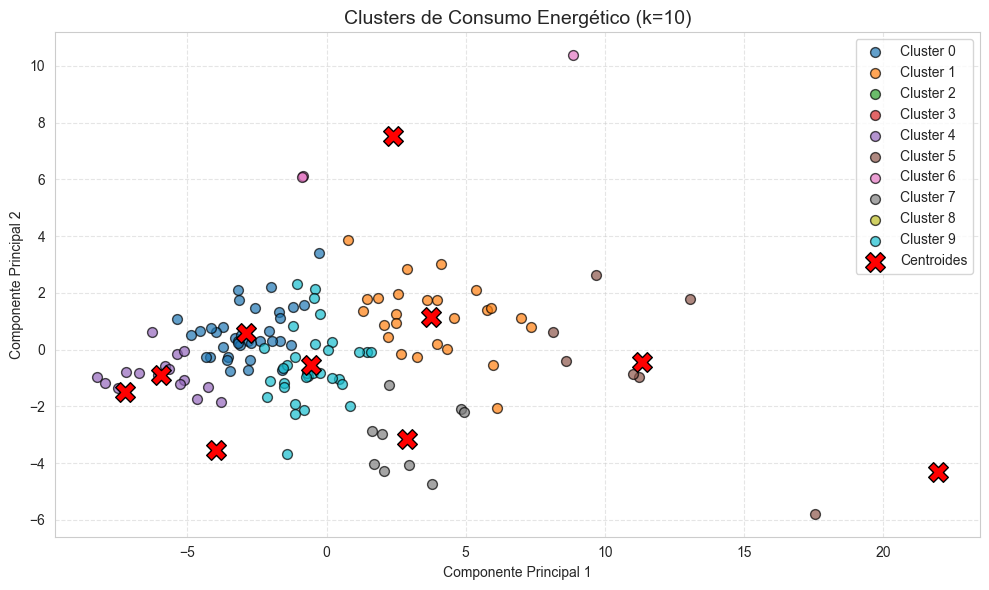

In [ ]:
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    plt.scatter(
        X_pca[labels == cluster, 0],
        X_pca[labels == cluster, 1],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.7,
        edgecolor='k',
        s=50
    )

# Centroides
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=200,
    c='red',
    edgecolor='k',
    label='Centroides'
)

plt.title(f'Clusters de Consumo Energético (k={best_k})', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2. PCA 3D

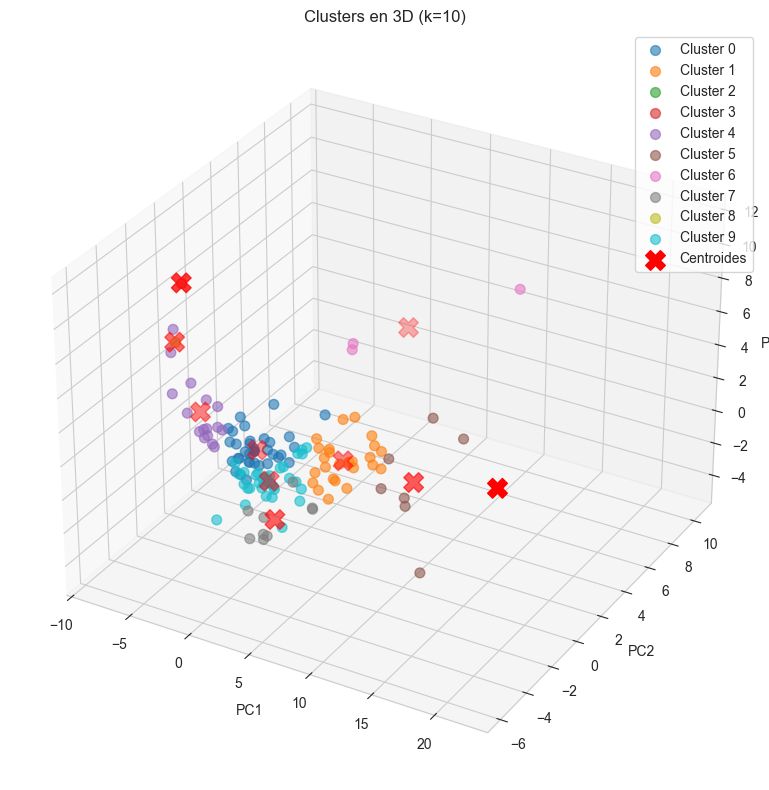

In [ ]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)
centroids_pca_3d = pca_3d.transform(centroids)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(best_k):
    ax.scatter(
        X_pca_3d[labels == cluster, 0],
        X_pca_3d[labels == cluster, 1],
        X_pca_3d[labels == cluster, 2],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.6,
        s=50
    )

ax.scatter(
    centroids_pca_3d[:, 0],
    centroids_pca_3d[:, 1],
    centroids_pca_3d[:, 2],
    marker='X',
    s=200,
    c='red',
    label='Centroides'
)

ax.set_title(f'Clusters en 3D (k={best_k})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()

### Visualización de Clusters de su Consumo Original

In [ ]:
df_original = pd.read_csv("../../../data/vertical_preprocessed_data_2.csv", sep=";")

cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_invierno)]

cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_otoño)]


df_clusters = df_features_final.reset_index()[['cups']].copy()
df_clusters['cluster'] = labels


df_final = pd.merge(df_original, df_clusters[['cups', 'cluster']], on='cups', how='left')

# Reordenar las columnas para que 'cluster' sea la segunda
column_order = ['cups', 'cluster'] + [col for col in df_final.columns if col not in ['cups', 'cluster']]
df_final = df_final[column_order]

df_final.to_csv('dataset/datos_consumo_con_clusters.csv', index=False, sep=';')

### 1. Distribución de Series por Cluster

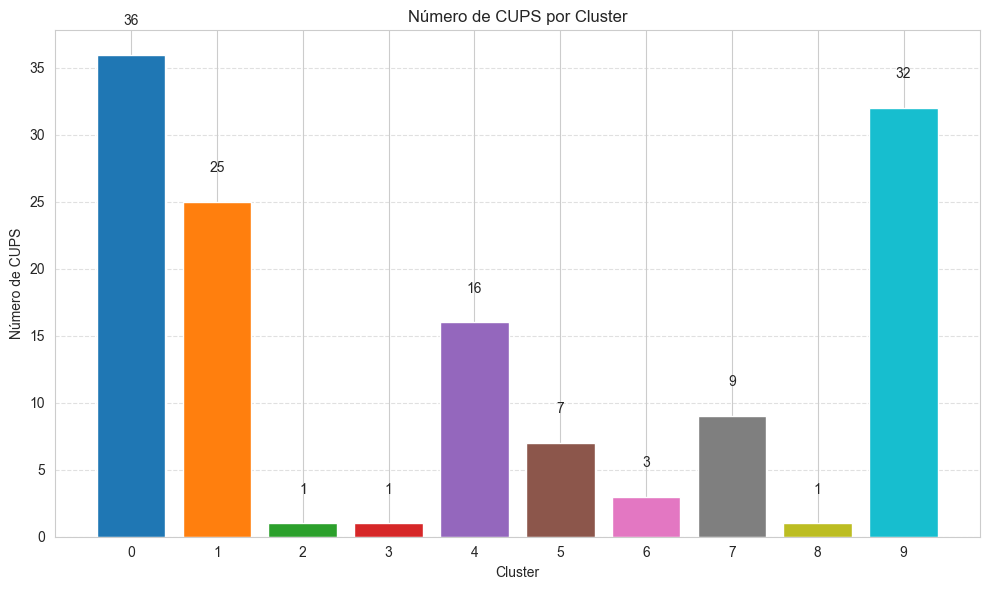

In [ ]:
cluster_counts = df_clusters['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    cluster_counts.index.astype(int),
    cluster_counts.values,
    color=[cluster_colors(int(i)) for i in cluster_counts.index]
)

plt.title('Número de CUPS por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de CUPS')
plt.xticks(cluster_counts.index.astype(int))
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 2,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### 2. Superposición de Series con Centroides

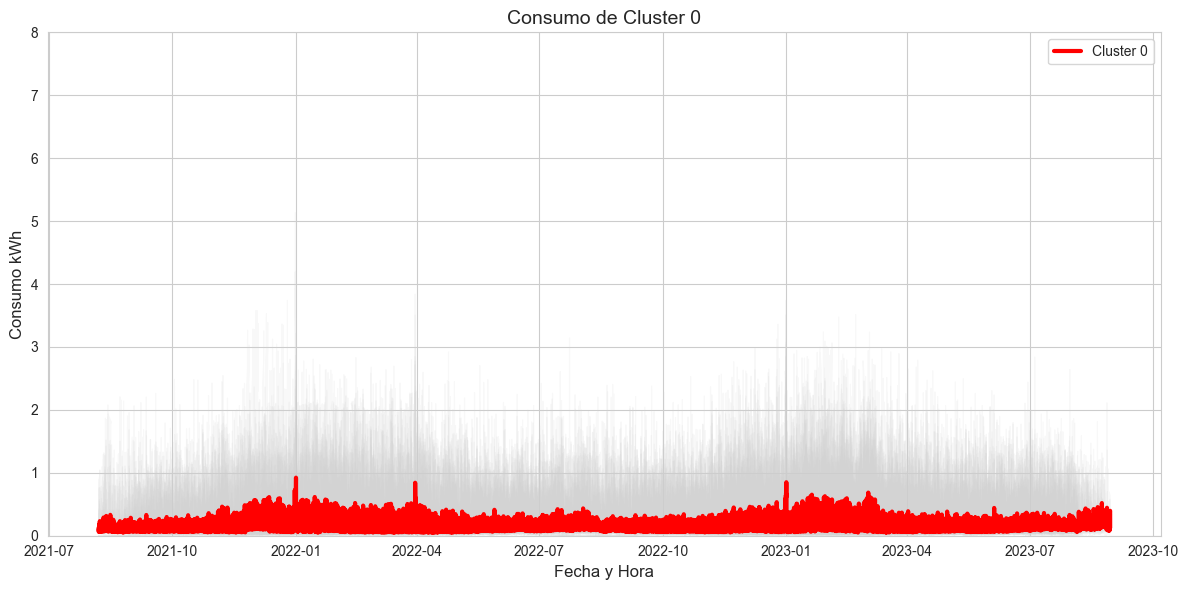

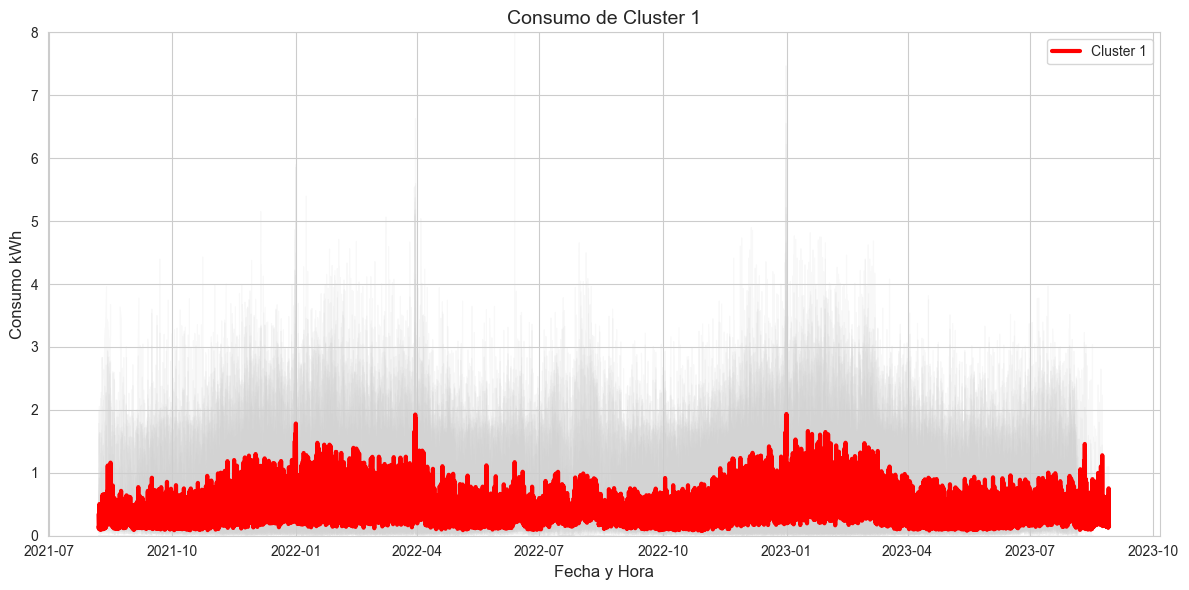

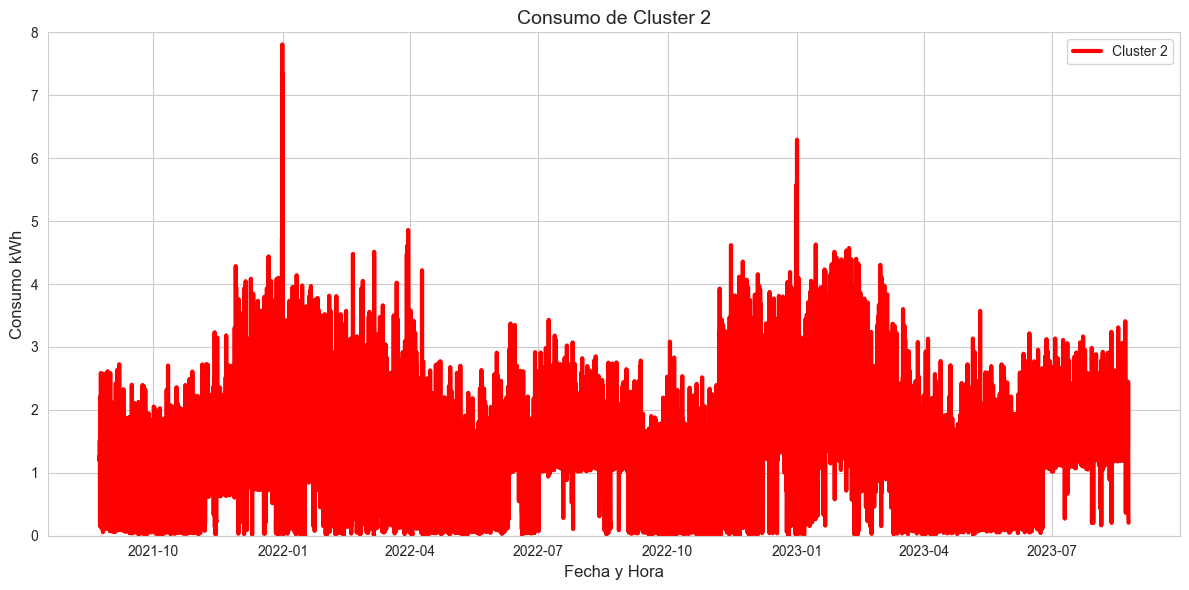

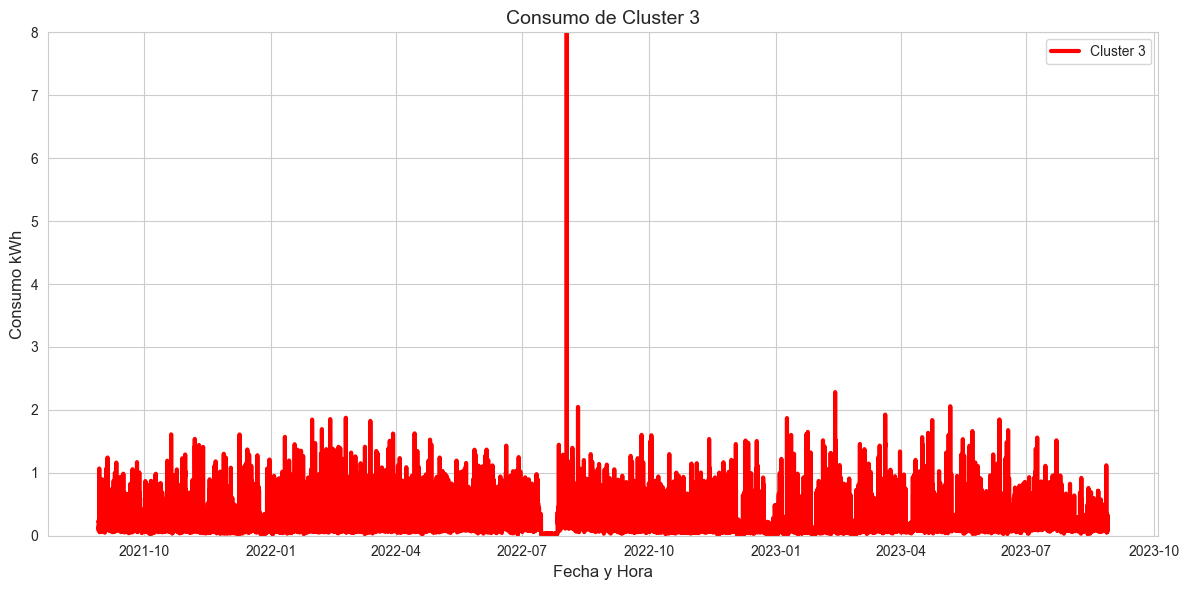

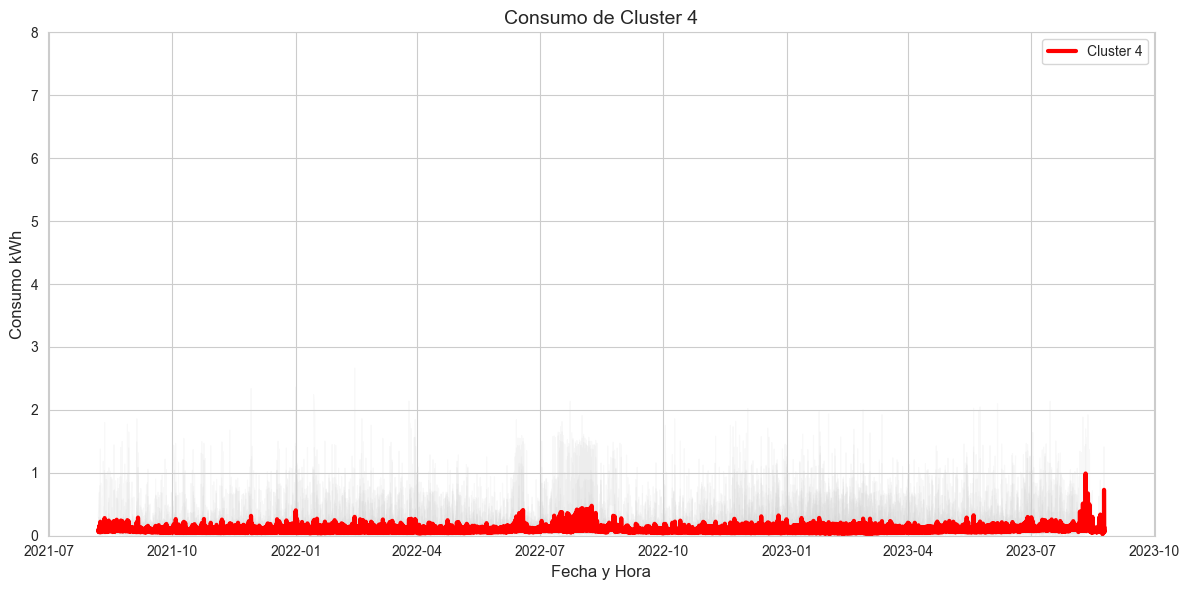

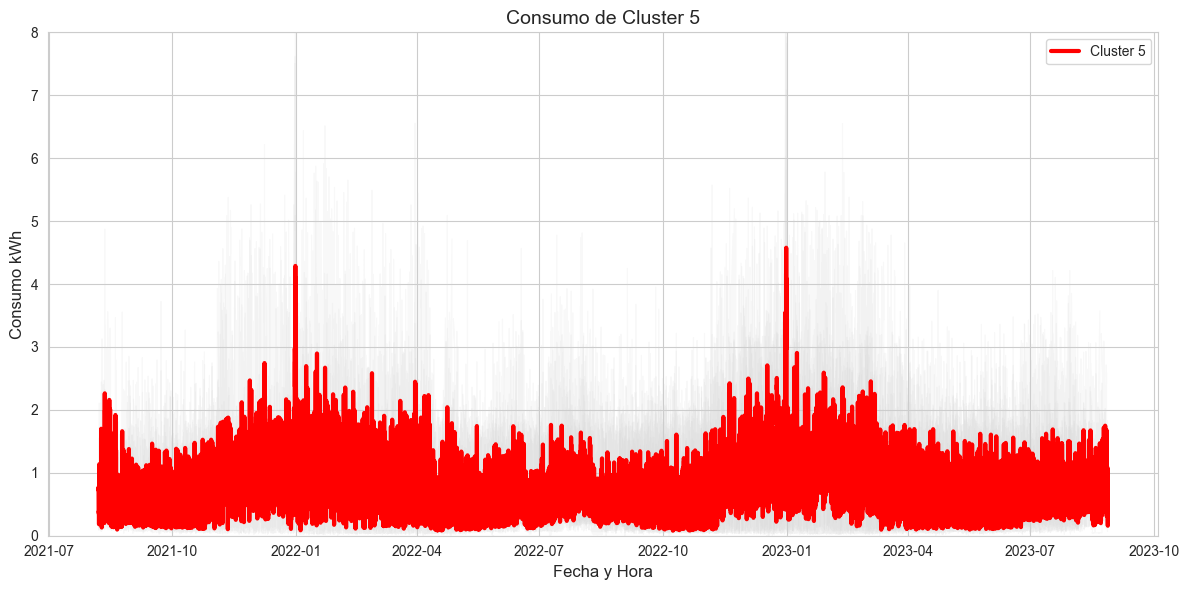

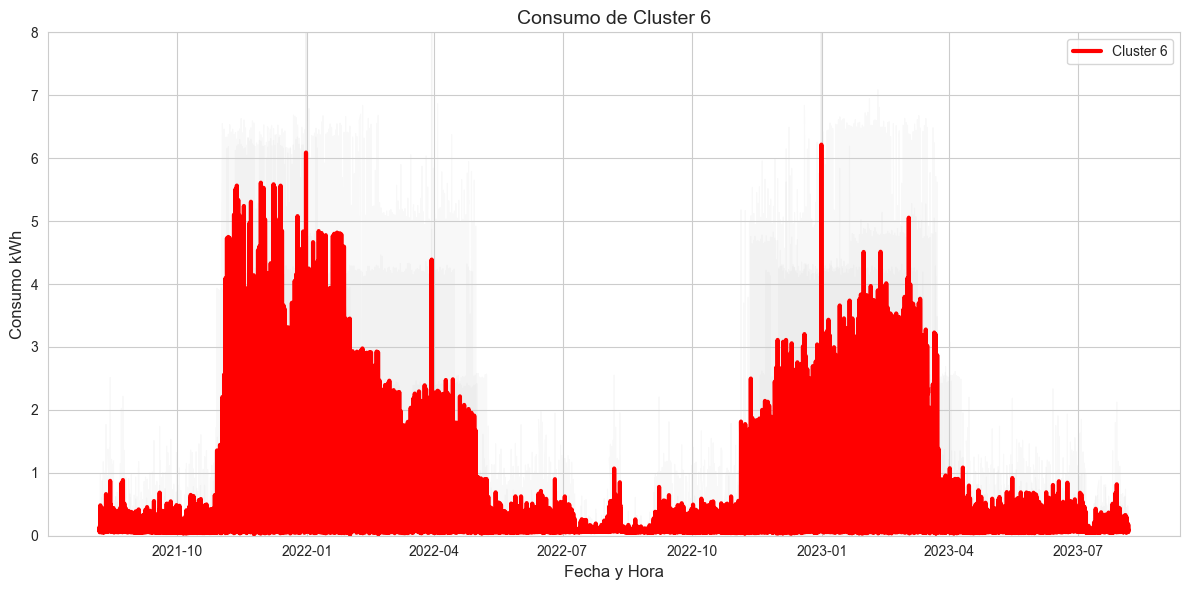

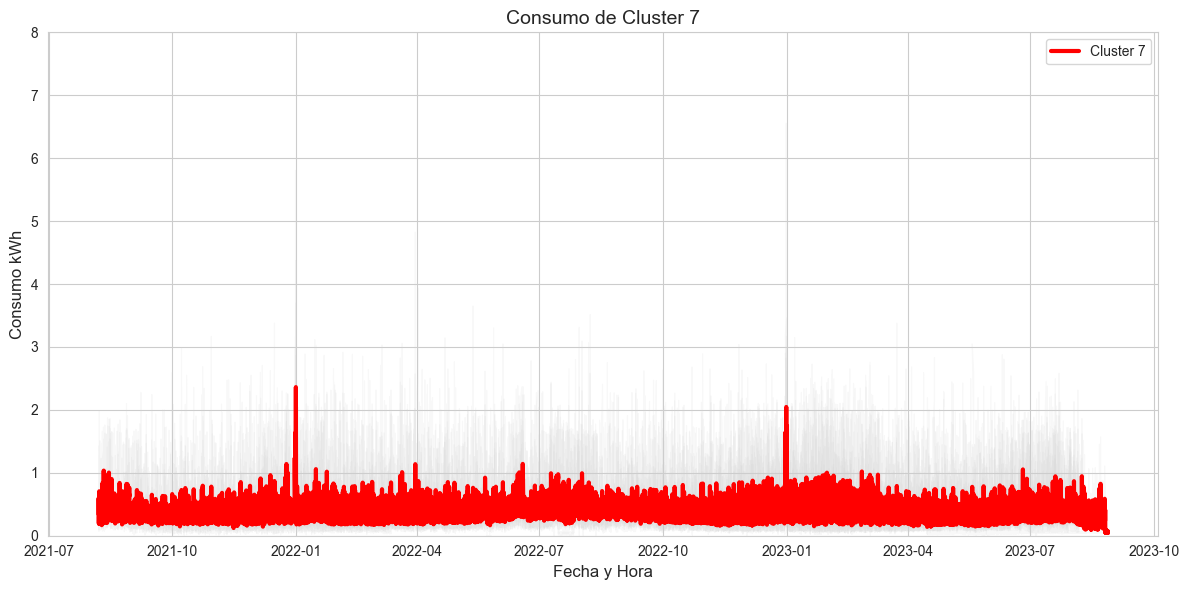

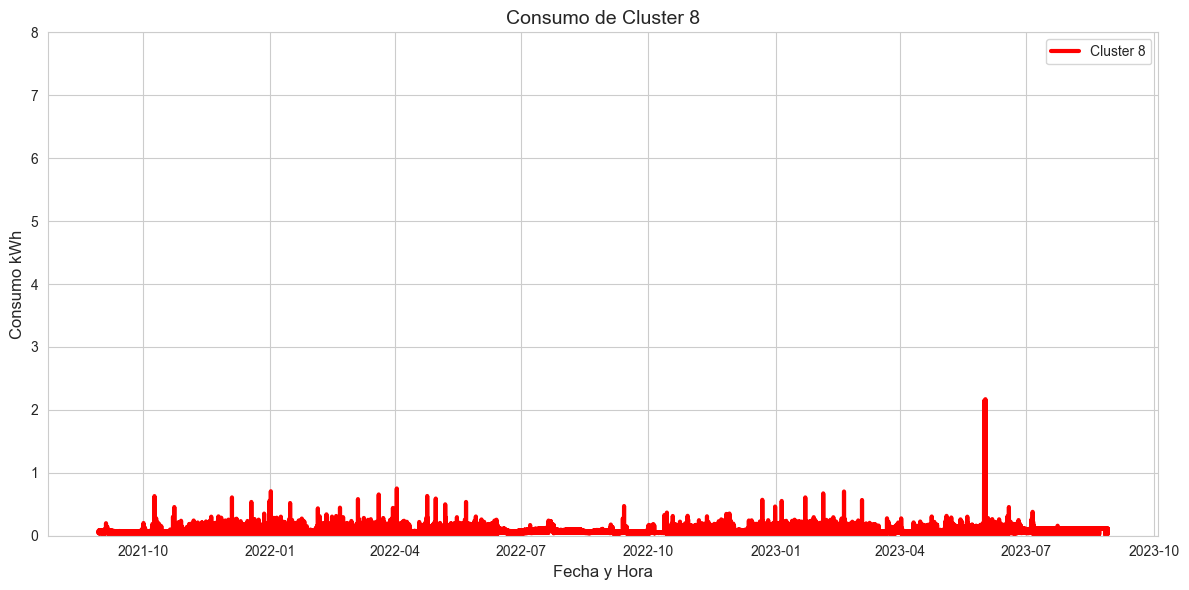

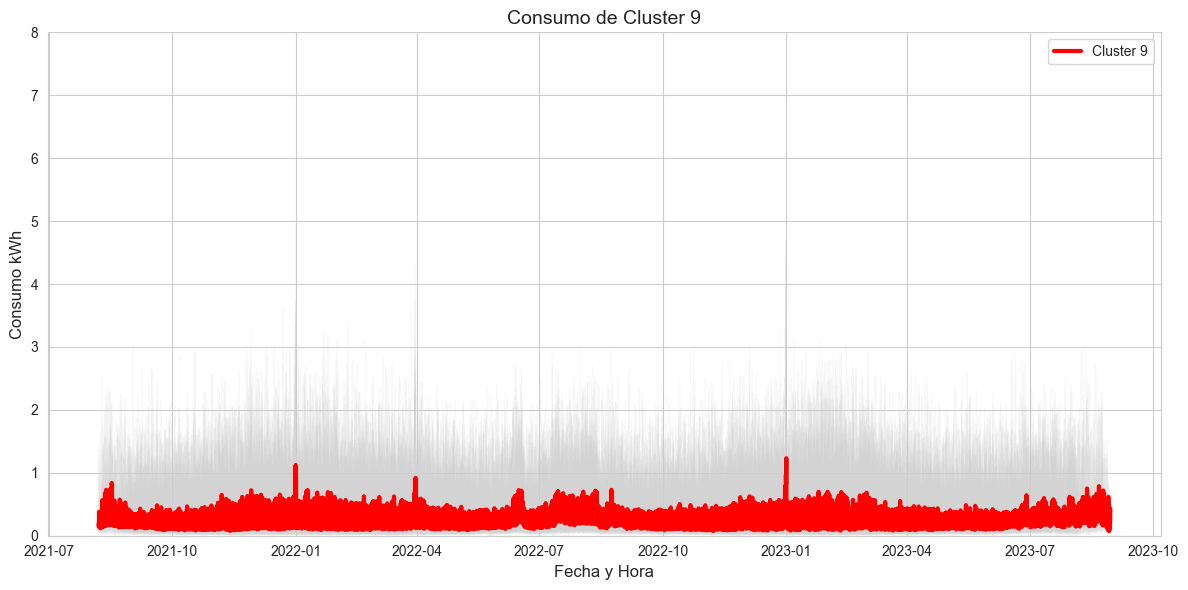

In [ ]:
df = pd.read_csv("dataset/datos_consumo_con_clusters.csv", sep=';')

df['hora'] = df['hora'].astype(int)

df['datetime'] = pd.to_datetime(df['fecha']) + pd.to_timedelta(df['hora'], unit='h')

clusters = sorted(df['cluster'].unique())

for cluster in clusters:
    plt.figure(figsize=(12, 6))

    cluster_data = df[df['cluster'] == cluster]
    
    for cups_id in cluster_data['cups'].unique():
        cups_series = cluster_data[cluster_data['cups'] == cups_id]
        plt.plot(cups_series['datetime'], cups_series['consumo_kWh'], color='lightgray', alpha=0.15, linewidth=0.8)
    
    cluster_center = cluster_data.groupby('datetime')['consumo_kWh'].mean()
    plt.plot(cluster_center.index, cluster_center.values, label=f'Cluster {int(cluster)}', linewidth=3, color='red')

    plt.title(f'Consumo de Cluster {int(cluster)}', fontsize=14)
    plt.xlabel('Fecha y Hora', fontsize=12)
    plt.ylabel('Consumo kWh', fontsize=12)
    plt.grid(True)
    plt.legend()
    
    # Fijar el rango del eje Y de 0 a 8 kWh
    plt.ylim(0, 8)
    
    plt.tight_layout()
    plt.show()
